#Imports

In [1]:
import librosa
import audioread
import numpy as np
#import scipy
import collections
import matplotlib.pyplot as plt
import os.path
#import IPython.display
%matplotlib inline

C:\Users\Arnulf\Anaconda3\lib\site-packages\librosa\core\audio.py:37: UserWarning: Could not import scikits.samplerate. Falling back to scipy.signal
  warnings.warn('Could not import scikits.samplerate. '


#Definitions

In [72]:
filename = "C:\\Users\\Arnulf\\Music\\Enjoy of SHINGO NAKAMURA.m4a"
sr = 16000
framesize = 2**12
n_blocks = 64
feature_dim = 84

kernel_size = 40

feature_buffer = collections.deque() #maxlen=horizon * n_blocks
rec_buffer = collections.deque() 

#Functions

In [3]:
def get_audiofile_duration(file):
    with audioread.audio_open(file) as f:
        return f.duration

In [5]:
def load(path, sr=None, mono=True, offset=0.0, duration=None,
         dtype=np.float32):
    
    y = []
    with audioread.audio_open(os.path.realpath(path)) as input_file:
        sr_native = input_file.samplerate
        n_channels = input_file.channels

        s_start = int(np.round(sr_native * offset)) * n_channels

        if duration is None:
            s_end = np.inf
        else:
            s_end = s_start + (int(np.round(sr_native * duration))
                               * n_channels)

        n = 0

        for frame in input_file:
            frame = librosa.util.buf_to_float(frame, dtype=dtype)
            n_prev = n
            n = n + len(frame)

            if n < s_start:
                # offset is after the current frame
                # keep reading
                continue

            if s_end < n_prev:
                # we're off the end.  stop reading
                break

            if s_end < n:
                # the end is in this frame.  crop.
                frame = frame[:s_end - n_prev]

            if n_prev <= s_start <= n:
                # beginning is in this frame
                frame = frame[(s_start - n_prev):]

            # tack on the current frame
            y.append(frame)

    if y:
        y = np.concatenate(y)

        if n_channels > 1:
            y = y.reshape((-1, 2)).T
            if mono:
                y = librosa.core.to_mono(y)

        if sr is not None:
            y = librosa.core.resample(y, sr_native, sr)

        else:
            sr = sr_native

    # Final cleanup for dtype and contiguity
    y = np.ascontiguousarray(y, dtype=dtype)

    return (y, sr)

In [9]:
def create_kernel(size):
    kernel = np.zeros([2*kernel_size+1, 2*kernel_size+1], dtype='int')
    kernel[:kernel_size, :kernel_size] = 1
    kernel[kernel_size+1:, kernel_size+1:] = 1
    kernel[kernel_size+1:, :kernel_size] = -1
    kernel[:kernel_size, kernel_size+1:] = -1
    return kernel

In [10]:
def correlate2d_diagonal(matrix, kernel):
    assert np.shape(matrix)[0] == np.shape(matrix)[1]
    assert np.shape(kernel)[0] == np.shape(kernel)[1]
    length = np.shape(matrix)[0]
    L = np.shape(kernel)[0]//2
    
    result = np.zeros(length)
    for i in range(length):
        for k in range(-L, L):
            if i+k < 0 or i+k >= length:
                break
            for l in range(-L, L):
                if i+l < 0 or i+l >= length:
                    break
                result[i] = result[i] + matrix[i+l, i+k] * kernel[L+l, L+k]
    return result

# Main Program

In [82]:
blocksize = n_blocks * 1/sr * framesize #seconds

horizon = 4 * n_blocks 
horizon_step = horizon//2

duration = get_audiofile_duration(filename)
segments = np.arange(0,180,blocksize) # replace fixed value with duration!

kernel = create_kernel(kernel_size)

feature_buffer.clear()
rec_buffer.clear()
recurrence_buffer = []
novelty_buffer = []

novelty_calc_matrix = np.zeros((2*horizon, 2*horizon))

# iterate through the whole file
for i, block in enumerate(segments):
    print("@block: ", block)
    y = load(filename, sr=sr, mono=True, offset=block, duration=blocksize)[0]
    # constant Q transform
    CQ = librosa.core.cqt(y, sr=sr, hop_length=framesize, fmin=None, n_bins=feature_dim, bins_per_octave=12, tuning=None, resolution=2, aggregate=None, norm=1, sparsity=0.01)
#    print("CQ shape:", np.shape(CQ))
    feature_buffer.extend(CQ.T)
#    print(np.shape(list(feature_buffer)))
    while len(feature_buffer) >= horizon:
        features = [feature_buffer.popleft() for x in range(0, horizon_step)]
        features.extend(list(feature_buffer)[:horizon_step])
        # compute recurrence matrix
#        R_CQ = librosa.segment.recurrence_matrix(np.array(list(feature_buffer)[:horizon]).T, k=None, width=1, metric='sqeuclidean', sym=True, axis=-1)       
        R_CQ = librosa.segment.recurrence_matrix(np.array(features).T, k=None, width=1, metric='sqeuclidean', sym=True, axis=-1)
#        rec_buffer.extend(R_CQ[:horizon_step, :horizon_step])
        rec_buffer.extend(R_CQ)
    
    while len(rec_buffer) >= 3*horizon:  
        novelty_calc_matrix[:horizon, :horizon] = [rec_buffer.popleft() for x in range(0, horizon)]
        novelty_calc_matrix[horizon_step:horizon+horizon_step, horizon_step:horizon+horizon_step] = np.array(list(rec_buffer)[:horizon])
        novelty_calc_matrix[horizon:2*horizon, horizon:2*horizon] = np.array(list(rec_buffer)[horizon:2*horizon])
        
        #print(np.shape(R_CQ))
#         if recurrence_buffer: # check if it's empty
#             recurrence_buffer.append(R_CQ[-1])
#         else:
#             recurrence_buffer.extend(R_CQ)
#        for j in range(0,)
#        feature_buffer.popleft() # throw away one feature vector

#        novelty = correlate2d_diagonal(R_CQ, kernel)

#     print("feature buffer:", len(feature_buffer))        
#     print("feature buffer pop shape:", np.shape(feature_buffer.popleft()))
#    feature_buffer.pop
    # recurrence matrix
#    R_CQ = recurrence_matrix(CQ, k=None, width=1, metric='sqeuclidean', sym=True, axis=-1)
#    print(np.shape(R_CQ))

@block:  0.0
@block:  16.384
@block:  32.768
@block:  49.152
@block:  65.536
@block:  81.92


ValueError: could not broadcast input array from shape (0) into shape (256,256)

In [57]:
#R_CQ = librosa.segment.recurrence_matrix(np.array(list(feature_buffer)).T, k=None, width=1, metric='sqeuclidean', sym=True, axis=-1)
np.shape(recurrence_buffer)
#print(len(list(feature_buffer)))
#print(feature_buffer.count)

(715, 256)

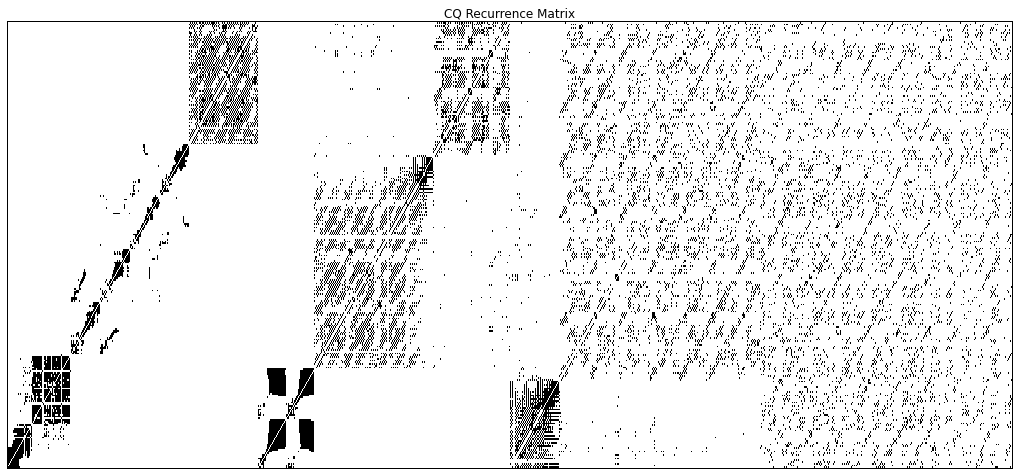

In [77]:
plt.figure(figsize=(18,8))

librosa.display.specshow(np.array(recurrence_buffer).T)

plt.title('CQ Recurrence Matrix')

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(novelty)
plt.ylabel('Novelty')
plt.show()